# FMLIKH Model: Steady-State Flow Curves

## Learning Objectives

1. Fit the **FMLIKH (Fractional Multi-Layer IKH)** model to flow curve data
2. Understand **multi-mode relaxation** with fractional memory
3. Analyze mode contributions to total stress
4. Compare single-mode FIKH vs multi-mode FMLIKH predictions
5. Use Bayesian inference for multi-modal parameter estimation
6. Calibrate parameters for downstream synthetic data generation

## Prerequisites

- NB01-NB06: FIKH tutorials (single-mode concepts)
- Bayesian inference fundamentals

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~5-8 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~20-30 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FMLIKH

# Robust path resolution for execution from any directory
from pathlib import Path
_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    load_ml_ikh_flow_curve,
    save_fikh_results,
    print_convergence_summary,
    print_parameter_comparison,
    compute_fit_quality,
    get_fmlikh_param_names,
    print_alpha_interpretation,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: FMLIKH Model

The **Fractional Multi-Layer IKH (FMLIKH)** model extends FIKH with multiple viscoelastic modes:

### Total Stress
$$
\sigma_{total} = \sum_{i=1}^{N} \sigma_i + \eta_{\infty} \dot{\gamma}
$$

Each mode $i$ has its own:
- $G_i$: Shear modulus
- $\eta_i$: Viscosity (defines $\tau_i = \eta_i / G_i$)
- $C_i$: Kinematic hardening modulus
- $\gamma_{dyn,i}$: Dynamic recovery parameter

### Shared Parameters
- Yield stress: $\sigma_{y0}$, $\Delta\sigma_y$
- Thixotropy: $\tau_{thix}$, $\Gamma$
- Fractional order: $\alpha$ (shared or per-mode)

### Why Multi-Mode?

1. **Broad relaxation spectra**: Real materials have multiple time scales
2. **Wide-frequency SAOS**: Single mode cannot capture full frequency range
3. **Complex startup**: Multiple overshoot features
4. **Prony-series-like**: Generalized Maxwell behavior

## 3. Load Data

In [3]:
# Load flow curve data
gamma_dot, stress = load_ml_ikh_flow_curve(instrument="ARES_up")

print(f"Data points: {len(gamma_dot)}")
print(f"Shear rate range: [{gamma_dot.min():.4f}, {gamma_dot.max():.2f}] 1/s")
print(f"Stress range: [{stress.min():.2f}, {stress.max():.2f}] Pa")

Data points: 21
Shear rate range: [0.0100, 100.00] 1/s
Stress range: [0.75, 51.46] Pa


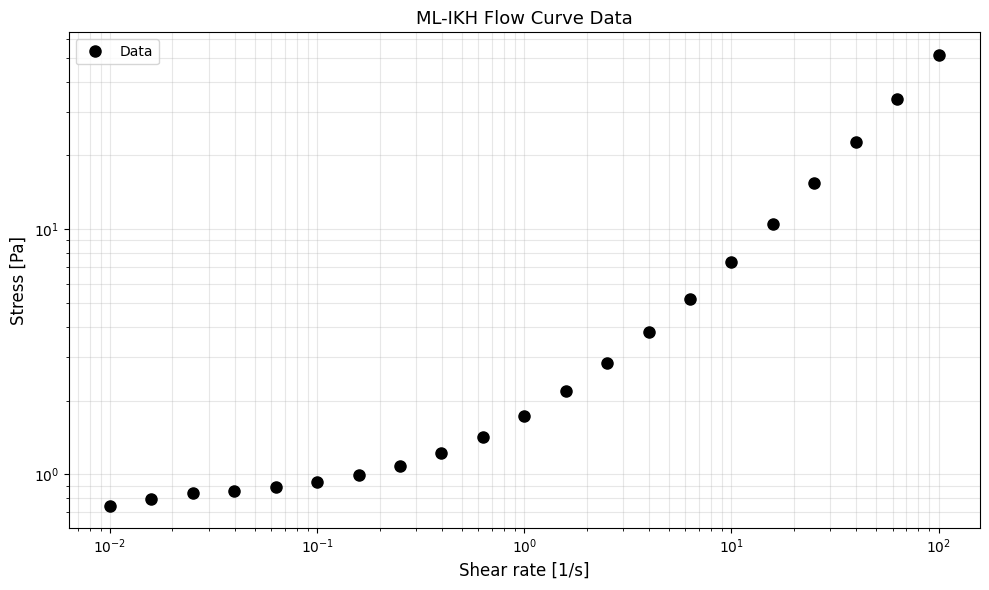

In [4]:
# Plot data
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=8, label="Data")
ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("ML-IKH Flow Curve Data", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
# Create FMLIKH model with 3 modes
N_MODES = 3
model = FMLIKH(
    n_modes=N_MODES,
    include_thermal=False,
    shared_alpha=True,
    alpha_structure=0.7,
)

print(f"FMLIKH with {N_MODES} modes")
print(f"Shared alpha: True")
print(f"Total parameters: {len(list(model.parameters.keys()))}")

FMLIKH with 3 modes
Shared alpha: True
Total parameters: 20


In [6]:
# Fit model
t0 = time.time()
model.fit(gamma_dot, stress, test_mode="flow_curve")
t_nlsq = time.time() - t0

param_names = get_fmlikh_param_names(n_modes=N_MODES, shared_alpha=True)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    try:
        val = model.parameters.get_value(name)
        print(f"  {name:15s} = {val:.4g}")
    except KeyError:
        pass

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=20 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.971315s


INFO:nlsq.least_squares:Convergence reason=`gtol` termination condition is satisfied. | iterations=21 | final_cost=4.1340 | elapsed=2.971s | final_gradient_norm=2.8138e-08


NLSQ fit time: 3.37 s

Fitted parameters:
  G_0             = 1000
  eta_0           = 1e+06
  C_0             = 500
  gamma_dyn_0     = 1
  G_1             = 100
  eta_1           = 1e+05
  C_1             = 50
  gamma_dyn_1     = 1
  G_2             = 10
  eta_2           = 1e+04
  C_2             = 5
  gamma_dyn_2     = 1
  m               = 1
  sigma_y0        = 0.4427
  delta_sigma_y   = 5.1e-07
  tau_thix        = 4.368e+08
  Gamma           = 9771
  eta_inf         = 0.5046
  mu_p            = 0.002799
  alpha_structure = 0.7


In [7]:
# Get mode information
mode_info = model.get_mode_info()

print("\nMode Information:")
print("=" * 60)
print(f"Shared alpha: {mode_info.get('alpha_shared', 'N/A'):.3f}")
print("\nPer-mode parameters:")
print(f"{'Mode':>6s}  {'G [Pa]':>12s}  {'η [Pa.s]':>12s}  {'τ [s]':>12s}")
print("-" * 60)
for mode in mode_info["modes"]:
    print(f"{mode['mode']:>6d}  {mode['G']:>12.4g}  {mode['eta']:>12.4g}  {mode['tau']:>12.4g}")


Mode Information:
Shared alpha: 0.700

Per-mode parameters:
  Mode        G [Pa]      η [Pa.s]         τ [s]
------------------------------------------------------------
     0          1000         1e+06          1000
     1           100         1e+05          1000
     2            10         1e+04          1000



Fit Quality:
  R^2:   0.997611
  RMSE:  0.6275 Pa


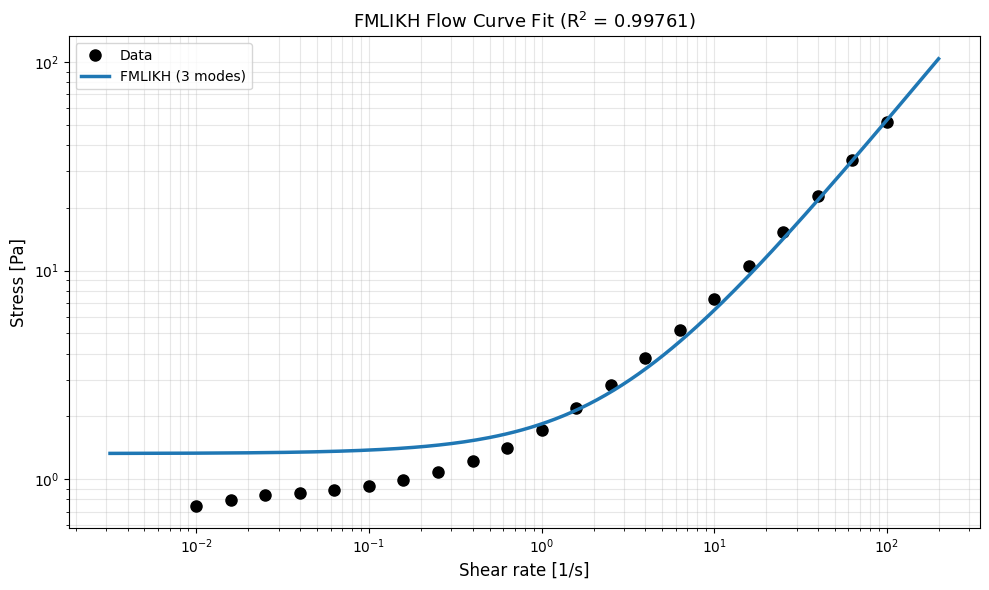

In [8]:
# Compute fit quality and plot
stress_pred = model.predict(gamma_dot, test_mode="flow_curve")
metrics = compute_fit_quality(stress, stress_pred)

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} Pa")

gamma_dot_fine = np.logspace(
    np.log10(gamma_dot.min()) - 0.5,
    np.log10(gamma_dot.max()) + 0.3,
    200,
)
stress_pred_fine = model.predict(gamma_dot_fine, test_mode="flow_curve")

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=8, label="Data")
ax.loglog(gamma_dot_fine, stress_pred_fine, "-", lw=2.5, color="C0", label=f"FMLIKH ({N_MODES} modes)")
ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title(f"FMLIKH Flow Curve Fit (R$^2$ = {metrics['R2']:.5f})", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Mode Decomposition

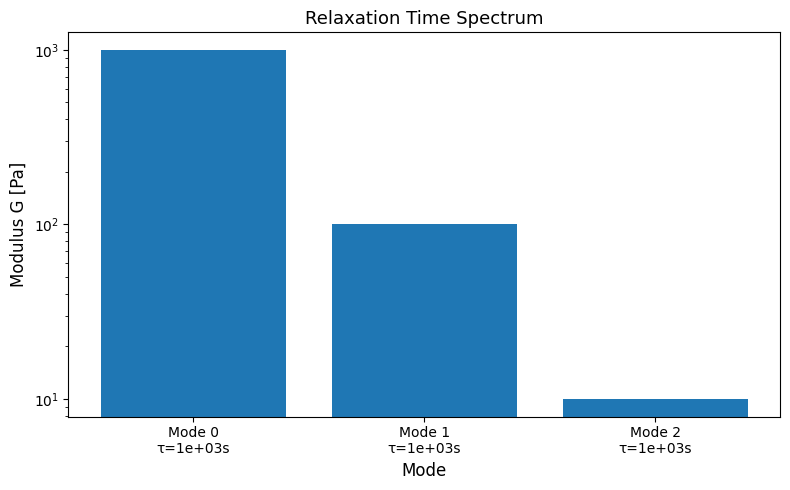

In [9]:
# Visualize relaxation time spectrum
mode_info = model.get_mode_info()

taus = [m["tau"] for m in mode_info["modes"]]
Gs = [m["G"] for m in mode_info["modes"]]

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(range(len(taus)), Gs, tick_label=[f"Mode {i}\nτ={t:.2g}s" for i, t in enumerate(taus)])
ax.set_xlabel("Mode", fontsize=12)
ax.set_ylabel("Modulus G [Pa]", fontsize=12)
ax.set_title("Relaxation Time Spectrum", fontsize=13)
ax.set_yscale("log")
plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Bayesian Inference

In [10]:
# Bayesian inference
initial_values = {}
for name in param_names:
    try:
        initial_values[name] = model.parameters.get_value(name)
    except KeyError:
        pass

NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model.fit_bayesian(
    gamma_dot,
    stress,
    test_mode="flow_curve",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 200 warmup + 500 samples x 1 chain(s)


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<11:07,  1.05it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   1%|          | 6/700 [00:01<01:35,  7.30it/s, 1023 steps of size 1.39e-03. acc. prob=0.51]

warmup:   1%|▏         | 9/700 [00:01<01:08, 10.04it/s, 1023 steps of size 1.14e-03. acc. prob=0.67]

warmup:   2%|▏         | 12/700 [00:01<00:53, 12.83it/s, 1023 steps of size 1.29e-03. acc. prob=0.75]

warmup:   2%|▏         | 16/700 [00:01<00:39, 17.31it/s, 1023 steps of size 1.77e-03. acc. prob=0.81]

warmup:   3%|▎         | 20/700 [00:01<00:33, 20.56it/s, 1023 steps of size 2.58e-03. acc. prob=0.85]

warmup:   3%|▎         | 24/700 [00:01<00:27, 24.55it/s, 1023 steps of size 3.80e-03. acc. prob=0.88]

warmup:   4%|▍         | 28/700 [00:01<00:24, 27.35it/s, 1023 steps of size 5.04e-03. acc. prob=0.89]

warmup:   5%|▍         | 32/700 [00:01<00:22, 29.57it/s, 1023 steps of size 6.98e-03. acc. prob=0.91]

warmup:   5%|▌         | 36/700 [00:02<00:22, 30.01it/s, 1023 steps of size 8.05e-03. acc. prob=0.91]

warmup:   6%|▌         | 40/700 [00:02<00:23, 28.60it/s, 511 steps of size 9.13e-03. acc. prob=0.92] 

warmup:   7%|▋         | 47/700 [00:02<00:17, 38.11it/s, 511 steps of size 1.13e-02. acc. prob=0.93]

warmup:   8%|▊         | 54/700 [00:02<00:14, 45.30it/s, 511 steps of size 1.29e-02. acc. prob=0.94]

warmup:   9%|▊         | 60/700 [00:02<00:13, 46.80it/s, 1023 steps of size 8.53e-03. acc. prob=0.94]

warmup:   9%|▉         | 65/700 [00:02<00:13, 47.30it/s, 1023 steps of size 6.15e-03. acc. prob=0.94]

warmup:  10%|█         | 70/700 [00:02<00:14, 43.65it/s, 1023 steps of size 7.09e-03. acc. prob=0.94]

warmup:  11%|█         | 76/700 [00:02<00:13, 46.24it/s, 1023 steps of size 8.84e-03. acc. prob=0.94]

warmup:  12%|█▏        | 81/700 [00:03<00:13, 44.30it/s, 1023 steps of size 7.25e-03. acc. prob=0.94]

warmup:  12%|█▏        | 86/700 [00:03<00:15, 39.29it/s, 1023 steps of size 7.20e-03. acc. prob=0.95]

warmup:  13%|█▎        | 91/700 [00:03<00:15, 38.32it/s, 1023 steps of size 6.99e-03. acc. prob=0.95]

warmup:  14%|█▎        | 95/700 [00:03<00:16, 37.21it/s, 1023 steps of size 7.86e-03. acc. prob=0.95]

warmup:  14%|█▍        | 99/700 [00:03<00:16, 35.55it/s, 1023 steps of size 7.92e-03. acc. prob=0.95]

warmup:  15%|█▍        | 104/700 [00:03<00:17, 34.98it/s, 1023 steps of size 4.90e-03. acc. prob=0.94]

warmup:  15%|█▌        | 108/700 [00:03<00:20, 28.90it/s, 1023 steps of size 3.08e-03. acc. prob=0.94]

warmup:  16%|█▌        | 112/700 [00:04<00:19, 30.07it/s, 1023 steps of size 3.45e-03. acc. prob=0.95]

warmup:  17%|█▋        | 116/700 [00:04<00:18, 30.92it/s, 1023 steps of size 4.05e-03. acc. prob=0.95]

warmup:  17%|█▋        | 120/700 [00:04<00:17, 32.61it/s, 1023 steps of size 4.79e-03. acc. prob=0.95]

warmup:  18%|█▊        | 124/700 [00:04<00:18, 30.95it/s, 1023 steps of size 5.54e-03. acc. prob=0.95]

warmup:  18%|█▊        | 129/700 [00:04<00:16, 33.64it/s, 1023 steps of size 6.22e-03. acc. prob=0.95]

warmup:  19%|█▉        | 133/700 [00:04<00:16, 35.16it/s, 511 steps of size 6.82e-03. acc. prob=0.95] 

warmup:  20%|█▉        | 138/700 [00:04<00:14, 38.54it/s, 511 steps of size 7.49e-03. acc. prob=0.95]

warmup:  20%|██        | 143/700 [00:04<00:14, 39.06it/s, 1023 steps of size 5.45e-03. acc. prob=0.95]

warmup:  21%|██        | 147/700 [00:05<00:15, 35.02it/s, 1023 steps of size 5.61e-03. acc. prob=0.96]

warmup:  22%|██▏       | 154/700 [00:05<00:13, 41.08it/s, 1023 steps of size 3.39e-03. acc. prob=0.95]

warmup:  23%|██▎       | 159/700 [00:05<00:13, 40.21it/s, 1023 steps of size 2.91e-03. acc. prob=0.95]

warmup:  23%|██▎       | 164/700 [00:05<00:14, 36.69it/s, 1023 steps of size 3.48e-03. acc. prob=0.95]

warmup:  24%|██▍       | 168/700 [00:05<00:15, 34.11it/s, 1023 steps of size 4.00e-03. acc. prob=0.95]

warmup:  25%|██▍       | 172/700 [00:05<00:15, 33.31it/s, 1023 steps of size 4.81e-03. acc. prob=0.96]

warmup:  25%|██▌       | 176/700 [00:05<00:15, 33.74it/s, 511 steps of size 4.97e-03. acc. prob=0.96] 

warmup:  26%|██▌       | 182/700 [00:05<00:13, 37.99it/s, 1023 steps of size 6.43e-03. acc. prob=0.96]

warmup:  27%|██▋       | 188/700 [00:06<00:11, 43.03it/s, 511 steps of size 7.01e-03. acc. prob=0.96] 

warmup:  28%|██▊       | 195/700 [00:06<00:10, 48.52it/s, 1023 steps of size 4.33e-03. acc. prob=0.96]

warmup:  29%|██▊       | 200/700 [00:06<00:11, 43.02it/s, 511 steps of size 5.25e-03. acc. prob=0.96] 

sample:  29%|██▉       | 205/700 [00:06<00:12, 39.21it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  30%|███       | 210/700 [00:06<00:13, 36.67it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  31%|███       | 214/700 [00:06<00:13, 35.71it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  31%|███       | 218/700 [00:06<00:14, 33.89it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  32%|███▏      | 222/700 [00:07<00:14, 32.91it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  32%|███▏      | 226/700 [00:07<00:14, 33.10it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  33%|███▎      | 232/700 [00:07<00:11, 39.06it/s, 511 steps of size 5.25e-03. acc. prob=0.99] 

sample:  34%|███▍      | 237/700 [00:07<00:12, 37.60it/s, 511 steps of size 5.25e-03. acc. prob=0.99]

sample:  34%|███▍      | 241/700 [00:07<00:12, 37.20it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  35%|███▌      | 245/700 [00:07<00:12, 37.47it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  36%|███▌      | 250/700 [00:07<00:11, 40.40it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  36%|███▋      | 255/700 [00:07<00:12, 34.82it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  37%|███▋      | 259/700 [00:07<00:12, 35.31it/s, 511 steps of size 5.25e-03. acc. prob=0.99] 

sample:  38%|███▊      | 263/700 [00:08<00:12, 34.67it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  38%|███▊      | 267/700 [00:08<00:13, 32.88it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  39%|███▊      | 271/700 [00:08<00:12, 34.04it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  39%|███▉      | 275/700 [00:08<00:13, 32.32it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  40%|████      | 280/700 [00:08<00:11, 36.08it/s, 511 steps of size 5.25e-03. acc. prob=0.99] 

sample:  41%|████      | 285/700 [00:08<00:10, 38.24it/s, 511 steps of size 5.25e-03. acc. prob=0.99]

sample:  41%|████▏     | 290/700 [00:08<00:11, 37.13it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  42%|████▏     | 295/700 [00:08<00:10, 38.45it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  43%|████▎     | 299/700 [00:09<00:11, 35.90it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  43%|████▎     | 304/700 [00:09<00:10, 39.01it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  44%|████▍     | 309/700 [00:09<00:10, 37.06it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  45%|████▍     | 313/700 [00:09<00:10, 36.77it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  45%|████▌     | 317/700 [00:09<00:10, 35.18it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  46%|████▌     | 321/700 [00:09<00:10, 35.26it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  47%|████▋     | 326/700 [00:09<00:09, 38.06it/s, 511 steps of size 5.25e-03. acc. prob=0.99] 

sample:  47%|████▋     | 330/700 [00:09<00:09, 37.51it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  48%|████▊     | 335/700 [00:10<00:08, 40.70it/s, 511 steps of size 5.25e-03. acc. prob=0.99] 

sample:  49%|████▊     | 340/700 [00:10<00:09, 36.95it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  49%|████▉     | 344/700 [00:10<00:10, 35.02it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  50%|████▉     | 348/700 [00:10<00:09, 35.71it/s, 511 steps of size 5.25e-03. acc. prob=0.99] 

sample:  50%|█████     | 352/700 [00:10<00:10, 32.74it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  51%|█████     | 357/700 [00:10<00:09, 35.18it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  52%|█████▏    | 361/700 [00:10<00:09, 34.78it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  52%|█████▏    | 365/700 [00:10<00:09, 33.85it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  53%|█████▎    | 369/700 [00:11<00:10, 31.89it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  54%|█████▎    | 376/700 [00:11<00:08, 39.50it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  54%|█████▍    | 381/700 [00:11<00:08, 37.33it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  55%|█████▌    | 385/700 [00:11<00:08, 36.08it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  56%|█████▌    | 390/700 [00:11<00:08, 37.80it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  56%|█████▋    | 394/700 [00:11<00:08, 37.10it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  57%|█████▋    | 398/700 [00:11<00:08, 35.40it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  57%|█████▋    | 402/700 [00:11<00:08, 33.67it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  58%|█████▊    | 406/700 [00:12<00:08, 32.79it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  59%|█████▊    | 411/700 [00:12<00:07, 36.27it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  59%|█████▉    | 416/700 [00:12<00:07, 38.96it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  60%|██████    | 421/700 [00:12<00:06, 40.89it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  61%|██████    | 426/700 [00:12<00:06, 39.53it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  62%|██████▏   | 431/700 [00:12<00:07, 36.65it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  62%|██████▏   | 435/700 [00:12<00:07, 34.40it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  63%|██████▎   | 439/700 [00:13<00:09, 26.62it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  63%|██████▎   | 443/700 [00:13<00:08, 28.59it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  64%|██████▍   | 447/700 [00:13<00:08, 28.93it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  64%|██████▍   | 451/700 [00:13<00:07, 31.19it/s, 511 steps of size 5.25e-03. acc. prob=0.99] 

sample:  65%|██████▌   | 455/700 [00:13<00:07, 30.64it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  66%|██████▌   | 459/700 [00:13<00:08, 29.54it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  66%|██████▌   | 463/700 [00:13<00:08, 29.49it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  67%|██████▋   | 467/700 [00:14<00:07, 30.37it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  67%|██████▋   | 471/700 [00:14<00:07, 31.57it/s, 511 steps of size 5.25e-03. acc. prob=0.99] 

sample:  68%|██████▊   | 475/700 [00:14<00:06, 33.05it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  68%|██████▊   | 479/700 [00:14<00:06, 34.78it/s, 511 steps of size 5.25e-03. acc. prob=0.99] 

sample:  69%|██████▉   | 484/700 [00:14<00:05, 37.30it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  70%|███████   | 490/700 [00:14<00:05, 41.93it/s, 511 steps of size 5.25e-03. acc. prob=0.99] 

sample:  71%|███████   | 495/700 [00:14<00:05, 39.18it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  71%|███████▏  | 499/700 [00:14<00:05, 38.58it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  72%|███████▏  | 503/700 [00:14<00:05, 36.63it/s, 511 steps of size 5.25e-03. acc. prob=0.99] 

sample:  72%|███████▏  | 507/700 [00:15<00:05, 33.76it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  73%|███████▎  | 511/700 [00:15<00:06, 30.96it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  74%|███████▎  | 515/700 [00:15<00:06, 29.64it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  74%|███████▍  | 521/700 [00:15<00:04, 36.19it/s, 511 steps of size 5.25e-03. acc. prob=0.99] 

sample:  75%|███████▌  | 525/700 [00:15<00:04, 35.07it/s, 511 steps of size 5.25e-03. acc. prob=0.99]

sample:  76%|███████▌  | 529/700 [00:15<00:05, 33.21it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  76%|███████▌  | 533/700 [00:15<00:05, 31.35it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  77%|███████▋  | 537/700 [00:16<00:05, 30.71it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  77%|███████▋  | 542/700 [00:16<00:04, 34.29it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  78%|███████▊  | 546/700 [00:16<00:04, 32.36it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  79%|███████▊  | 550/700 [00:16<00:04, 34.00it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  79%|███████▉  | 555/700 [00:16<00:03, 37.21it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  80%|███████▉  | 559/700 [00:16<00:03, 37.32it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  80%|████████  | 563/700 [00:16<00:03, 37.02it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  81%|████████  | 568/700 [00:16<00:03, 40.05it/s, 511 steps of size 5.25e-03. acc. prob=0.99] 

sample:  82%|████████▏ | 573/700 [00:16<00:03, 35.89it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  82%|████████▏ | 577/700 [00:17<00:03, 36.25it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  83%|████████▎ | 581/700 [00:17<00:03, 35.15it/s, 511 steps of size 5.25e-03. acc. prob=0.99] 

sample:  84%|████████▎ | 586/700 [00:17<00:02, 38.84it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  84%|████████▍ | 591/700 [00:17<00:02, 39.38it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  85%|████████▌ | 596/700 [00:17<00:02, 37.68it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  86%|████████▌ | 600/700 [00:17<00:02, 37.64it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  86%|████████▋ | 604/700 [00:17<00:02, 37.75it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  87%|████████▋ | 609/700 [00:17<00:02, 40.98it/s, 511 steps of size 5.25e-03. acc. prob=0.99] 

sample:  88%|████████▊ | 614/700 [00:18<00:01, 43.33it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  88%|████████▊ | 619/700 [00:18<00:01, 42.69it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  89%|████████▉ | 624/700 [00:18<00:01, 43.43it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  90%|████████▉ | 629/700 [00:18<00:01, 43.63it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  91%|█████████ | 634/700 [00:18<00:01, 42.79it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  91%|█████████▏| 639/700 [00:18<00:01, 41.47it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  92%|█████████▏| 644/700 [00:18<00:01, 38.13it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  93%|█████████▎| 648/700 [00:18<00:01, 36.23it/s, 511 steps of size 5.25e-03. acc. prob=0.99] 

sample:  93%|█████████▎| 652/700 [00:19<00:01, 35.67it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  94%|█████████▍| 657/700 [00:19<00:01, 38.49it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  94%|█████████▍| 661/700 [00:19<00:01, 36.41it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  95%|█████████▌| 665/700 [00:19<00:01, 31.39it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  96%|█████████▌| 669/700 [00:19<00:01, 28.58it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  96%|█████████▌| 672/700 [00:19<00:00, 28.54it/s, 511 steps of size 5.25e-03. acc. prob=0.99] 

sample:  96%|█████████▋| 675/700 [00:19<00:00, 27.46it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  97%|█████████▋| 679/700 [00:19<00:00, 30.22it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  98%|█████████▊| 684/700 [00:20<00:00, 33.51it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  98%|█████████▊| 688/700 [00:20<00:00, 35.08it/s, 511 steps of size 5.25e-03. acc. prob=0.99] 

sample:  99%|█████████▉| 692/700 [00:20<00:00, 35.24it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample:  99%|█████████▉| 696/700 [00:20<00:00, 34.66it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:20<00:00, 35.79it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:20<00:00, 34.19it/s, 1023 steps of size 5.25e-03. acc. prob=0.99]


Bayesian inference time: 24.8 s


In [11]:
# Convergence (check key parameters)
key_params = ["G_0", "G_1", "G_2", "alpha_structure", "sigma_y0", "tau_thix"]
all_pass = print_convergence_summary(result, key_params)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_0    1.0000       500      PASS
            G_1    1.0000       500      PASS
            G_2    1.0000       500      PASS
alpha_structure    1.0000       500      PASS
       sigma_y0    1.0000       500      PASS
       tau_thix    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED


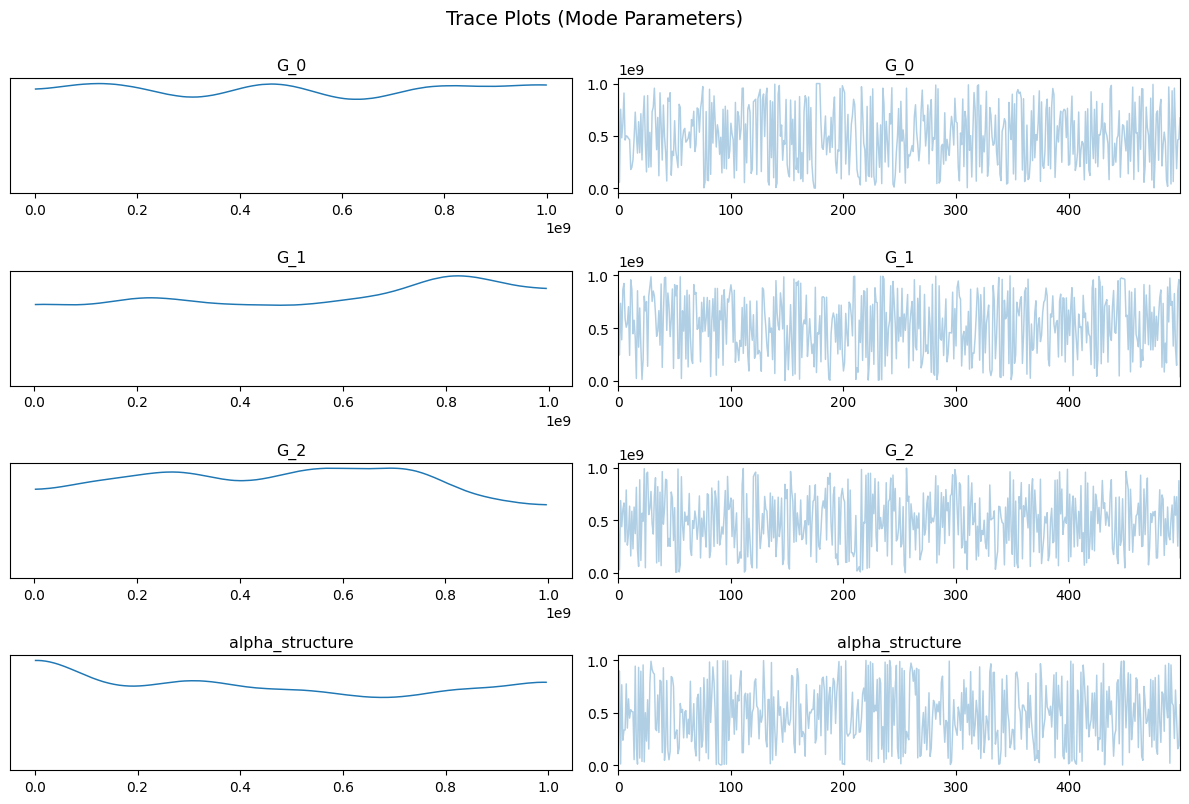

In [12]:
# Trace plots for mode parameters
idata = result.to_inference_data()
mode_params = ["G_0", "G_1", "G_2", "alpha_structure"]
axes = az.plot_trace(idata, var_names=mode_params, figsize=(12, 8))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots (Mode Parameters)", fontsize=14, y=1.00)
plt.tight_layout()
display(fig)
plt.close(fig)

In [13]:
# Parameter comparison
posterior = result.posterior_samples
print_parameter_comparison(model, posterior, key_params)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
            G_0          1000     4.956e+08  [3.993e+07, 9.74e+08]
            G_1           100     5.428e+08  [2.112e+07, 9.767e+08]
            G_2            10     4.911e+08  [3.526e+07, 9.585e+08]
alpha_structure           0.7        0.4639  [0.00984, 0.9877]
       sigma_y0        0.4427        0.4463  [0.338, 0.5487]
       tau_thix     4.368e+08     5.274e+11  [2.528e+10, 9.71e+11]


## 7. Save Results

In [14]:
save_fikh_results(model, result, "fmlikh", "flow_curve", param_names)
print("\nParameters saved for synthetic data in NB09, NB11.")

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fmlikh/flow_curve/
  nlsq_params_flow_curve.json: 20 parameters
  posterior_flow_curve.json: 500 draws

Parameters saved for synthetic data in NB09, NB11.


## Key Takeaways

1. **FMLIKH extends FIKH with multiple relaxation modes**
2. **Multi-mode captures broad relaxation spectra** in real materials
3. **Shared alpha** reduces parameters while maintaining memory effects
4. **Mode decomposition** shows contribution of each time scale
5. **More parameters require careful initialization** and longer inference

### Next Steps

- **NB08**: Startup shear (multi-mode overshoot)
- **NB09**: Stress relaxation (multi-exponential decay)
- **NB10**: Creep (distributed time scales)
- **NB11**: SAOS (broadened spectra)
- **NB12**: LAOS (multi-mode harmonics)